In [ ]:
!pip install einops
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cpu')

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/project')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle

W = 224
H = 224
root_folder = "lung-and-colon-cancer-histopathological-images/lung_colon_image_set"

label_to_class = {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}

data = {'image_path': [], 'label': []}

for folder in os.listdir(root_folder):
    dataset = os.path.join(root_folder, folder)
    for sub_folder in os.listdir(dataset):
        img_folder = os.path.join(dataset, sub_folder)
        cls = label_to_class.get(sub_folder, -1)
        if cls == -1:
            continue

        for img_name in os.listdir(img_folder):
            img_path = os.path.join(img_folder, img_name)
            data['image_path'].append(img_path)
            data['label'].append(cls)

df = pd.DataFrame(data)
df = shuffle(df, random_state=0)



In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_images = list(zip(train_df['image_path'], train_df['label']))
test_images = list(zip(test_df['image_path'], test_df['label']))


In [ ]:
train_df.shape,test_df.shape

((18967, 2), (4742, 2))

In [ ]:
from torchvision import datasets, transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


class CustomImageDataset(datasets.VisionDataset):
    def __init__(self, image_label_pairs, transform=None):
        super().__init__(root="", transform=transform)
        self.image_paths = [img[0] for img in image_label_pairs]
        self.labels = [img[1] for img in image_label_pairs]
        self.transform = transform
        self.classes = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = datasets.folder.default_loader(img_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


In [ ]:
from torch.utils.data import DataLoader


image_datasets = {
    'train': CustomImageDataset(train_images, transform=data_transforms['train']),
    'test': CustomImageDataset(test_images, transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=8, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=8, shuffle=False, num_workers=4)
}
print(f"Training set size: {len(image_datasets['train'])}")
print(f"Test set size: {len(image_datasets['test'])}")


Training set size: 18967
Test set size: 4742


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class_names = image_datasets['train'].classes
class_names

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tqdm import tqdm

class CustomViTModel(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(CustomViTModel, self).__init__()
        self.vit = vit_model
        self.vit.heads = nn.Identity()

        # Add custom layers
        self.fc1 = nn.Linear(768, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.vit(x).last_hidden_state[:, 0]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
num_classes =5
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)

2024-08-13 18:17:43.345587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 18:17:43.345732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 18:17:43.485497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:

epochs = 10
lr = 0.0001
gamma = 0.7
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(dataloaders['train']):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output.logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs=output.logits
        acc = (outputs.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(dataloaders['train'])
        epoch_loss += loss / len(dataloaders['train'])

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in dataloaders['test']:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output.logits, label)
            outputs=val_output.logits
            acc = (outputs.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(dataloaders['test'])
            epoch_val_loss += val_loss / len(dataloaders['test'])

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/2500 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2500/2500 [06:43<00:00,  6.22it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2500/2500 [06:43<00:00,  6.19it/s]


Epoch : 1 - loss : 0.1129 - acc: 0.9663 - val_loss : 0.0363 - val_acc: 0.9888



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 2 - loss : 0.0401 - acc: 0.9873 - val_loss : 0.1719 - val_acc: 0.9598



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 3 - loss : 0.0395 - acc: 0.9876 - val_loss : 0.0116 - val_acc: 0.9960



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 4 - loss : 0.0292 - acc: 0.9900 - val_loss : 0.0037 - val_acc: 0.9990



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 5 - loss : 0.0224 - acc: 0.9927 - val_loss : 0.0330 - val_acc: 0.9888



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 6 - loss : 0.0221 - acc: 0.9934 - val_loss : 0.0040 - val_acc: 0.9986



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 7 - loss : 0.0164 - acc: 0.9947 - val_loss : 0.0043 - val_acc: 0.9990



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 8 - loss : 0.0195 - acc: 0.9940 - val_loss : 0.0023 - val_acc: 0.9996



100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Epoch : 9 - loss : 0.0153 - acc: 0.9949 - val_loss : 0.0096 - val_acc: 0.9962



100%|██████████| 2500/2500 [06:42<00:00,  6.22it/s]


Epoch : 10 - loss : 0.0159 - acc: 0.9951 - val_loss : 0.0569 - val_acc: 0.9846



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()

all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for data, label in dataloaders['test']:
        data = data.to(device)
        label = label.to(device)


        output = model(data)
        output=output.logits
        preds = output.argmax(dim=1)

        # Collect predictions and true labels
        all_test_labels.extend(label.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())


test_labels_np = np.array(all_test_labels)
test_preds_np = np.array(all_test_preds)



In [ ]:
unique_values, counts = np.unique(test_preds_np, return_counts=True)

# Print unique values and their counts
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3 4]
Counts: [1007  998 1022  935 1038]


In [ ]:
class_names=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

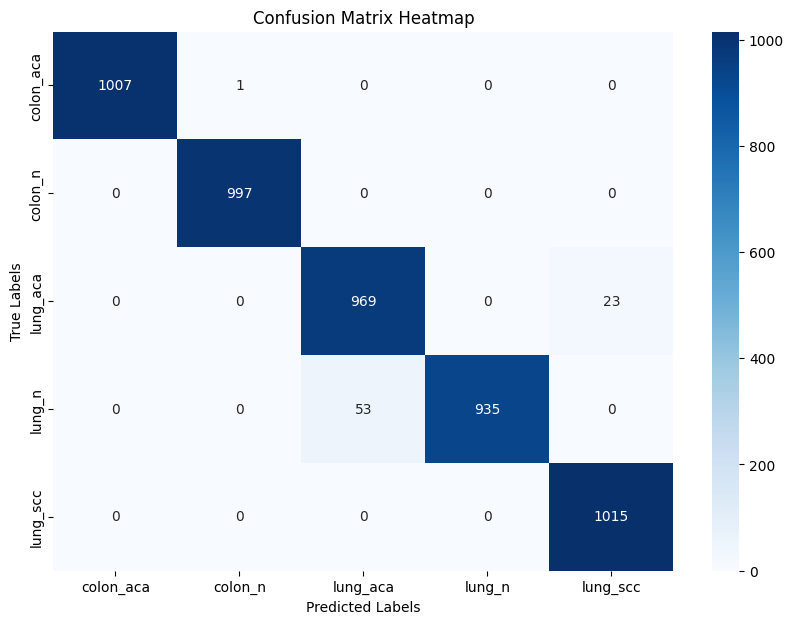

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

label_mapping = {i: name for i, name in enumerate(class_names)}

test_labels_str = np.array([label_mapping[label] for label in test_labels_np])
test_preds_str = np.array([label_mapping[label] for label in test_preds_np])

test_confusion_matrix = confusion_matrix(test_labels_str, test_preds_str, labels=class_names)

plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
class_report = classification_report(test_labels_str, test_preds_str, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00      1008
     colon_n       1.00      1.00      1.00       997
    lung_aca       0.95      0.98      0.96       992
      lung_n       1.00      0.95      0.97       988
    lung_scc       0.98      1.00      0.99      1015

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.99      0.98      0.98      5000



In [ ]:
import torch

torch.save(model.state_dict(), 'pretrained_model_weights.pth')
torch.save(model, 'pretrained_full_model.pth')